# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.73'

In [2]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [3]:
import os
df2=pf.merge_fit_files(path=os.getcwd())

## First, get the metadata for this day

In [5]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=meta_path,
file_ext=file_ext, exclude_str=['Ne', 'FG', 'Cap','window','Spec'],
 sort=True)
diad_meta[0]

'002 KS23_103_FIC.txt'

## Now get all the important information out of the metadata files

In [6]:
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=diad_meta, prefix=prefix, str_prefix=prefix_str,
trupower=TruPower)
meta.head()

100%|██████████| 90/90 [00:00<00:00, 1496.45it/s]

Done


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,KS23_103_FIC.txt,"September 21, 2023\n",September,21.0,12.203,60.0,4.0,50.0,"['0h', '4m', '1s']",9:30:49 AM\n,34249.0,1325.004
1,KS23_103_FID_Rep1.txt,"September 21, 2023\n",September,21.0,20.104,60.0,4.0,100.0,"['0h', '4m', '2s']",10:09:11 AM\n,36551.0,1325.004
2,KS23_103_FID_Rep2.txt,"September 21, 2023\n",September,21.0,20.182,60.0,4.0,100.0,"['0h', '4m', '1s']",10:14:12 AM\n,36852.0,1325.004
3,KS23_104_FIB.txt,"September 21, 2023\n",September,21.0,12.043,60.0,4.0,50.0,"['0h', '4m', '2s']",10:34:14 AM\n,38054.0,1325.004
4,KS23_104_FIA_Rep1.txt,"September 21, 2023\n",September,21.0,12.037,60.0,4.0,50.0,"['0h', '4m', '1s']",10:39:44 AM\n,38384.0,1325.004


## Then get a simple file name you can stitch with the spectra

In [7]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'KS23_103_FIC'

## Now get filename from spectra into same form as metadata

In [8]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
KS23_103_FIC


In [9]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,KS23_103_FIC,103.279400,0.002996,1285.555215,0.002742,668.548153,1285.555265,1007.083737,0.567730,2.115686,...,September,21.0,12.203,60.0,4.0,50.0,"['0h', '4m', '1s']",9:30:49 AM\n,34249.0,1325.004
1,KS23_103_FID_Rep1,103.315079,0.003569,1285.554921,0.003205,563.881538,1285.554971,875.545214,0.604232,2.368691,...,September,21.0,20.104,60.0,4.0,100.0,"['0h', '4m', '2s']",10:09:11 AM\n,36551.0,1325.004
2,KS23_103_FID_Rep2,103.309593,0.003313,1285.563048,0.003016,683.311590,1285.563098,1010.492186,0.570080,2.696670,...,September,21.0,20.182,60.0,4.0,100.0,"['0h', '4m', '1s']",10:14:12 AM\n,36852.0,1325.004
3,KS23_104_FIB,103.313276,0.006400,1285.565530,0.005746,387.682242,1285.565580,590.819622,0.579880,2.600113,...,September,21.0,12.043,60.0,4.0,50.0,"['0h', '4m', '2s']",10:34:14 AM\n,38054.0,1325.004
4,KS23_104_FIA_Rep1,103.376209,0.019154,1285.474890,0.017676,90.299539,1285.474890,148.812208,0.623329,1.959308,...,September,21.0,12.037,60.0,4.0,50.0,"['0h', '4m', '1s']",10:39:44 AM\n,38384.0,1325.004


## If you have secondary phases, now is the time to merge those in

In [10]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=prefix_str, file_ext=file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

Made a df!
good job, no duplicate file names


## Now we calculate the density using the UC Berkeley Densimeter. 
- If you have your own densimeter, I am happy to add a function for it if you email me (penny_wieser@berkeley.edu)
- This particular function propagates the uncertainty on 1) The neon line correction model 2) the peak fits of the diads themselves 3) The densimeter. 

In [11]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,sec since midnight,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,time,preferred_values,lower_values,upper_values
0,KS23_103_FIC,0.114374,0.004013,0.001231,0.003819,103.038904,0.003108,0.000850,0.002996,12.203,...,34249.0,1150.769579,319.48218,207.330604,Spline,0.128733,34249.0,0.997671,0.997663,0.997680
1,KS23_103_FID_Rep1,0.127491,0.004106,0.001449,0.003842,103.072008,0.003658,0.000839,0.003569,20.104,...,36551.0,NaN,NaN,NaN,NaN,NaN,36551.0,0.997647,0.997639,0.997655
2,KS23_103_FID_Rep2,0.125201,0.004068,0.001351,0.003837,103.066227,0.003410,0.000837,0.003313,20.182,...,36852.0,NaN,NaN,NaN,NaN,NaN,36852.0,0.997644,0.997636,0.997652
3,KS23_104_FIB,0.126187,0.004610,0.002551,0.003839,103.068716,0.006439,0.000832,0.006400,12.043,...,38054.0,NaN,NaN,NaN,NaN,NaN,38054.0,0.997633,0.997625,0.997641
4,KS23_104_FIA_Rep1,0.150940,0.008525,0.007579,0.003903,103.131186,0.019127,0.000831,0.019154,12.037,...,38384.0,NaN,NaN,NaN,NaN,NaN,38384.0,0.997630,0.997622,0.997638


In [12]:
# This cell saves the merged together dataframe with the folder name and the date you fitted it
from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
sorted_df.to_excel(name)

Raman_session_September 21, 2023_fitted_2023-09-21.xlsx


## This helps visualize the errors on each spectra 

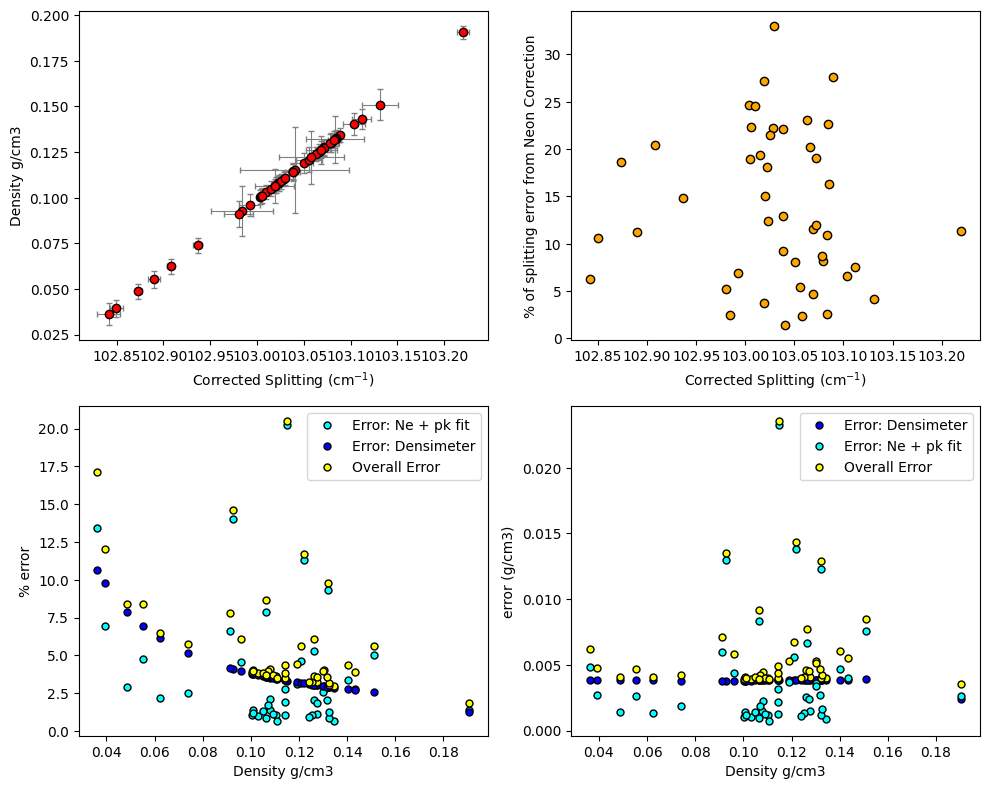

In [14]:
df=sorted_df
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
df=df.loc[df['Density g/cm3']>0]
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

## IF FIs
- This calculates an estimated pressure of entrapment based on a temperature you have estimated

Text(0, 0.5, '# of FI')

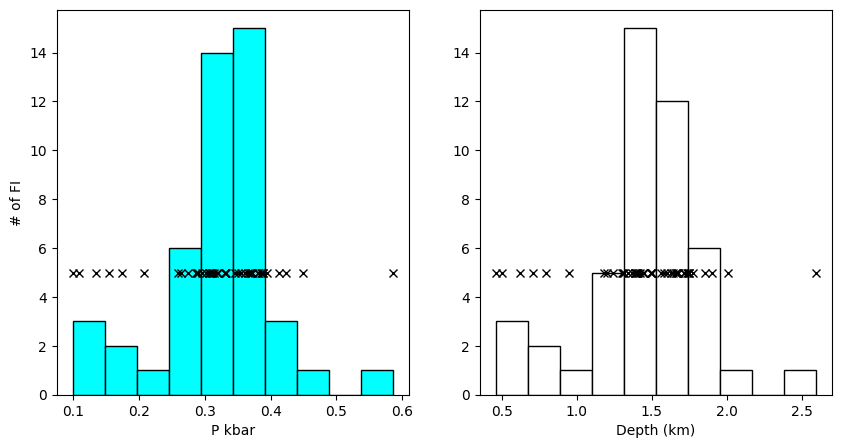

In [15]:
# Calculate pressure with a temperature estimate
Temp_C=1150
Pressure_SW96=pf.calculate_P_for_rho_T(T_K=Temp_C+273.15,
                CO2_dens_gcm3=df['Density g/cm3'],
                 EOS='SP94')
# Calculate depth from a crustal density assumption
Depth=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'], 
                model='ryan_lerner')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Pressure_SW96['P_kbar'], ec='k', fc='cyan', bins=10)
ax1.plot(Pressure_SW96['P_kbar'], Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.plot(Depth, Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.hist(Depth, ec='k', fc='white', bins=10)
ax1.set_xlabel('P kbar')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of FI')

In [16]:
df

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,sec since midnight,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,time,preferred_values,lower_values,upper_values
0,KS23_103_FIC,0.114374,0.004013,0.001231,0.003819,103.038904,0.003108,0.000850,0.002996,12.203,...,34249.0,1150.769579,319.482180,207.330604,Spline,0.128733,34249.0,0.997671,0.997663,0.997680
1,KS23_103_FID_Rep1,0.127491,0.004106,0.001449,0.003842,103.072008,0.003658,0.000839,0.003569,20.104,...,36551.0,NaN,NaN,NaN,NaN,NaN,36551.0,0.997647,0.997639,0.997655
2,KS23_103_FID_Rep2,0.125201,0.004068,0.001351,0.003837,103.066227,0.003410,0.000837,0.003313,20.182,...,36852.0,NaN,NaN,NaN,NaN,NaN,36852.0,0.997644,0.997636,0.997652
3,KS23_104_FIB,0.126187,0.004610,0.002551,0.003839,103.068716,0.006439,0.000832,0.006400,12.043,...,38054.0,NaN,NaN,NaN,NaN,NaN,38054.0,0.997633,0.997625,0.997641
4,KS23_104_FIA_Rep1,0.150940,0.008525,0.007579,0.003903,103.131186,0.019127,0.000831,0.019154,12.037,...,38384.0,NaN,NaN,NaN,NaN,NaN,38384.0,0.997630,0.997622,0.997638
5,KS23_104_FIA_Rep2,0.140151,0.006079,0.004686,0.003871,103.103958,0.011827,0.000829,0.011826,14.907,...,38820.0,NaN,NaN,NaN,NaN,NaN,38820.0,0.997626,0.997618,0.997634
6,KS23_303_FIA,0.114253,0.004409,0.002202,0.003819,103.038598,0.005557,0.000820,0.005510,12.005,...,41383.0,NaN,NaN,NaN,NaN,NaN,41383.0,0.997604,0.997597,0.997612
7,KS23_303_FIB,0.107814,0.004094,0.001494,0.003811,103.022347,0.003770,0.000817,0.003689,11.984,...,42280.0,NaN,NaN,NaN,NaN,NaN,42280.0,0.997598,0.997590,0.997606
8,KS23_201_FIC_50X,0.134332,0.003961,0.000903,0.003857,103.089273,0.002280,0.000814,0.002135,12.039,...,43787.0,1150.769579,911.800471,597.840942,Spline,0.157003,43787.0,0.997587,0.997579,0.997595
9,KS23_201_FID_50X,0.127339,0.004518,0.002378,0.003841,103.071624,0.006000,0.000814,0.005959,12.020,...,44090.0,1150.799077,89.921750,59.522600,Spline,0.071782,44090.0,0.997585,0.997577,0.997593


Text(0, 0.5, 'SO2/Diadratio')

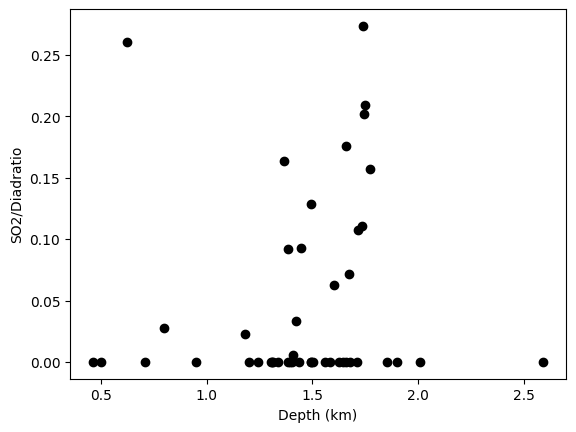

In [17]:
plt.plot(Depth, df['SO2_Diad_Ratio'].fillna(0), 'ok')
plt.xlabel('Depth (km)')
plt.ylabel('SO2/Diadratio')

In [18]:
df.columns

Index(['filename', 'Density g/cm3', 'σ Density g/cm3',
       'σ Density g/cm3 (from Ne+peakfit)',
       'σ Density g/cm3 (from densimeter)', 'Corrected_Splitting',
       'Corrected_Splitting_σ', 'Corrected_Splitting_σ_Ne',
       'Corrected_Splitting_σ_peak_fit', 'power (mW)', 'Spectral Center',
       'Preferred D_σ_Ne', 'Preferred D_σ_pkfit', 'in range', 'Notes',
       'LowD_RT', 'HighD_RT', 'LowD_SC', 'LowD_SC_σ', 'MedD_SC', 'MedD_SC_σ',
       'HighD_SC', 'HighD_SC_σ', 'Temperature', 'Splitting', 'Split_σ',
       'Diad1_Combofit_Cent', 'Diad1_cent_err', 'Diad1_Combofit_Height',
       'Diad1_Voigt_Cent', 'Diad1_Voigt_Area', 'Diad1_Voigt_Sigma',
       'Diad1_Residual', 'Diad1_Prop_Lor', 'Diad1_fwhm', 'Diad1_refit',
       'Diad2_Combofit_Cent', 'Diad2_cent_err', 'Diad2_Combofit_Height',
       'Diad2_Voigt_Cent', 'Diad2_Voigt_Area', 'Diad2_Voigt_Sigma',
       'Diad2_Voigt_Gamma', 'Diad2_Residual', 'Diad2_Prop_Lor', 'Diad2_fwhm',
       'Diad2_refit', 'HB1_Cent', 'HB1_Area', '